### Schrödingergleichung

$$i\hbar\frac{\partial \psi(x,t)}{\partial t} = \hat{H} \psi(x,t)$$

Für zeitunabhängige Hamiltonoperatoren ist die Zeitentwicklung eines Zustands

$$\psi(x,t) = \sum_{n=0}^{\infty} c_n e^{-iE_n(t-t_0)/\hbar } \,\phi^{(n)}(x), \quad c_n = \langle \phi^{(n)}|\psi(t_0)\rangle$$

mit orthogonalen Eigenzuständen $\phi^{(n)}$ und reellen Energieeigenwerten $E_n$ als Lösung der stationären Schrödingergleichung

$$\hat{H}\phi = E\phi$$

### Eigenzustände - numerisch

Räumlich beschränktes Teilchen in 1D:

$$\hat{H} = -\frac{\hbar^2}{2m}\frac{\mathrm{d}^2}{\mathrm{d}x^2} + V(x)$$

$$\phi(0) = \phi(L) = 0$$

$$\langle\phi|\psi\rangle = \int_0^L \phi^*(x) \psi(x) \mathrm{d}x$$

- Dimensionslose Größen ($x' = x / L, t' = \frac{t}{mL^2}, V' = mL^2V, E' = mL^2E$, wobei im Folgenden $'$ weggelassen) und Konvention $\hbar=1$:

$$\left[-\frac{1}{2}\frac{\mathrm{d}^2}{\mathrm{d}{x}^2} + V(x)\right]\mathclose{}\phi(x) = E\phi(x)$$

$$\phi(0) = \phi(1) = 0$$

- Diskretisierung ($\phi_j \approx \frac{\phi_{j-1}-2\phi_j+\phi_{j+1}}{\Delta x^2}$ mit $\phi_j = \phi(j\Delta x);\: \phi_0 = \phi_N = 0;\: \Delta x = 1/N$ ) ergibt ein lineares System mit tridiagonaler Matrix:

$$
\begin{bmatrix}\frac{1}{\Delta x^2}+V_1 & -\frac{1}{2 \Delta x^2} & \hphantom{\frac{1}{\Delta x^2}+V_1} &\\[10pt]
-\frac{1}{2 \Delta x^2} & \ddots & \ddots &\\[10pt]
& \ddots & \ddots & -\frac{1}{2 \Delta x^2}\\[10pt]
& \hphantom{\frac{1}{\Delta x^2}+V_1} & -\frac{1}{2 \Delta x^2} & \frac{1}{\Delta x^2}+V_{N-1}\end{bmatrix}
\begin{bmatrix} \phi_1 \\ \vdots \\ \phi_{N-1} \end{bmatrix} = E \begin{bmatrix} \phi_1 \\ \vdots \\ \phi_{N-1} \end{bmatrix}
$$

### Implementation

- eigenstates & animation

In [83]:
#%pip install plotly
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import HTML

def eigenstates(potential, N=500):
    """
    Lösung für ein räumlich beschränktes Teilchen.

    Parameters:
    -----------
    potential : callable
        Potential V(x) innerhalb eines unendlichen Potentialkasten für x in [0,1].
    N : int, optional (default=500)
        Anzahl der Diskretisierungspunkte.
    
    Returns:
    --------
    x : numpy.ndarray, shape (N,)
        Positionen.
    E_n : numpy.ndarray, shape (N-2,)
        Energieeigenwerte.
    phi_n : numpy.ndarray, shape (N-2, N)
        Eigenzustände phi_n(x) in Zeilen.
    """
    N -= 1
    dx = 1 / N
    x = np.linspace(0, 1, N+1)
    d = 1/dx**2 + np.vectorize(potential)(x[1:-1]) # diagonal
    e = np.full(len(d)-1, -1/(2*dx**2)) # off-diagonal
    E_n, phi_n = eigh_tridiagonal(d, e)
    phi_n = np.pad(phi_n.T, ((0, 0), (1, 1))) # include boundary values
    norm = np.sum(np.abs(phi_n)**2, axis=1) * dx # normalize rows
    phi_n /= norm[:, np.newaxis]
    return x, E_n, phi_n

def eigenstates_animation(x, potential, E_n, phi_n, n_max=10, use_box_border=True, show_trail=True, potential_latex_expr=None, show_energies=False):
    # TODO: phi_n complex? -> plot Re, Im, abs + limit ylims different
    # but bound, confined eigenstates seem to be real
    E_n = E_n[:n_max+1]
    N = len(E_n)
    phi_n = phi_n[:n_max+1,:]
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]]) # fig = go.Figure()

    # Potential plot
    V = np.vectorize(potential)(x)
    fig.add_trace(
        go.Scatter(
            visible=True,
            name=r'$\text{Potential}$',
            x=x,
            y=V,
            line=dict(color='rgb(89, 117, 109)'),
            ),
        secondary_y=True)
    
    # Potential well border plot: arrows or filled box
    if not use_box_border:
        arrow_length = max(1, np.max(V))
        arrows = []
        for arrow_x in [0, 1]:
            arrow = go.layout.Annotation(
                x=arrow_x, y=arrow_length,
                xref="x", yref="y2",
                ax=arrow_x, ay=0,
                axref="x", ayref='y2',
                text="", yanchor="top",
                showarrow=True,
                arrowhead=2, arrowwidth=2, arrowcolor='rgb(89, 117, 109)')
            arrows.append(arrow)
        fig.update_layout(annotations=arrows)
    if use_box_border:
        for box_x in [(-0.02, 0), (1, 1.02)]:
            fig.add_shape(
                type="rect",
                x0=box_x[0],
                y0=min(-1, np.min(V)),
                x1=box_x[1],
                y1=max(1, np.max(V)),
                fillcolor='rgb(89, 117, 109)',  # lighter: 'rgb(145, 164, 163)'
                line=dict(width=2, color='rgb(89, 117, 109)'), # lighter: 'rgb(145, 164, 163)'
                xref="x", yref="y2")
     
    # Add traces and steps for slider
    steps = []
    padding_len = len(str(n_max)) # only for legend n zero padding
    for i, E_i in enumerate(E_n):
        # Add animated plot corresponding to slider
        visible_beginning = i == 0 # first one visible even before startin animation
        fig.add_trace(
            go.Scatter(
                visible=visible_beginning,
                name=rf'$\text{{Wellenfunktion n={i:0{padding_len}d}}}$', # TEXT f'Wellenfunktion $\phi_{{n={i}}}(x)', TODO: fix changing length latex
                x=x,
                y=phi_n[i,:],
                line=dict(color='rgb(245, 110, 73)')))

        if show_trail:
            # Add color alpha trail plot of all Eigenstates, TODO: only plot j<i
            for j, phi in enumerate(phi_n):
                alpha = 0.5 * np.exp(-0.8 * abs(j - i)) * (j<i)
                alpha *= (alpha>0.01)
                fig.add_trace(
                    go.Scatter(
                        visible=False,
                        showlegend=False,
                        x=x,
                        y=phi,
                        line=dict(color=f'rgba(245, 110, 73, {alpha})')))

        # Visibility of traces depending depending on slider position:
        if show_trail:
            # True at slider position + trail (together length N+1) + first trace is always visible potential plot
            visible = [True] + [False]*(N+1)*i + [True]*(N+1) + [False]*(N+1)*(N-i-1)
        else:
            visible = [True] + [False]*N
            visible[i+1] = True
        step = dict(
            method="update",
            args=[{"visible": visible}, {"title": rf"$\text{{Eigenzustand zu }}E_{{{i}}} = {E_i:.2f}\text{{ TODO:Einheiten.}}$"}],
            label=str(i))
        steps.append(step)

    # Create slider
    slider = go.layout.Slider(
        currentvalue={"prefix": "n: "},
        pad={"t": 50},
        steps=steps,
        len=1)
    
    title = "Eigenzustände für ein gegebenes Potential."
    if potential_latex_expr:
        title = rf"$\text{{Eigenzustände für das Potential }}{potential_latex_expr}.$"

    fig.update_layout(
        sliders=[slider],
        title=title,
        showlegend=True)
    
    #fig.update_yaxes(title_text="Wellenfunktion", range=[np.min(phi_n)*1.05, np.max(phi_n)*1.05], secondary_y=False)
    #fig.update_yaxes(title_text='Potential', range=[min(-1, np.min(V))*1.05, arrow_length*1.05], secondary_y=True)
    fig.update_yaxes(title_text=r'$\phi$', showgrid=False, title_font=dict(color='rgb(245, 110, 73)'), tickfont=dict(color='rgb(245, 110, 73)'), secondary_y=False)
    fig.update_yaxes(title_text=r'$V \cdot m L^2$', showgrid=False, title_font=dict(color='rgb(89, 117, 109)'), tickfont=dict(color='rgb(89, 117, 109)'), secondary_y=True)

    # Energies plot - for testing purposes - TODO: proper energies plot
    if show_energies:
        fig_energies, ax = plt.subplots()
        plt.hlines(1,0,np.max(E_n))
        plt.xlim(0,np.max(E_n))
        plt.ylim(0.5,1.5)
        y = np.ones_like(E_n)
        plt.plot(E_n,y,'|',ms = 40, label='$E_n \cdot m L^2 / \hbar^2$')
        plt.axis('off')
        # Analytical Energies for infinite well
        E_n_ana = [np.pi**2 * n**2 / 2 for n in range(1, n_max+2)]
        plt.plot(E_n_ana,y,'|',ms = 20, label='$E_{n, analytisch} \cdot m L^2 / \hbar^2$')
        plt.legend()
        plt.show()

    return fig

- TEST:

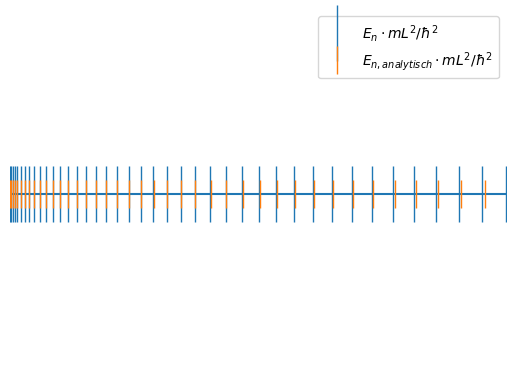

In [92]:
""" def potential(x, mu=0.5, sigma=0.05):
    return -1e4 * np.exp(-(x - mu)**2 / (2*sigma**2)) """

def potential(x):
    return 0

x, E_n, phi_n = eigenstates(potential)

fig = eigenstates_animation(x, potential, E_n, phi_n, use_box_border=True, n_max=40, show_trail=False, show_energies=True)
fig.show() # Use HTML(fig.to_html()) in jupyterlab instead.
fig.write_html('plot.html', include_mathjax='cdn')

- TODO:
    - Einheiten, E spacing plot
    - more potentials: step, delta, ... add selection menu -> html OR interactive input field -> jhub
    - plot analytical solutions; check normalization
    - embed plot into HTML version of notebook (hide a view code cells before html export) OR embed only HTML plot in moodle etc..

- Potential input field in jupyter notebook

In [91]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create input fields to change paramters of plot and a button to display the animation

input_widget_func = widgets.Text(
    value='0',
    placeholder='Enter sympy expression here...',
    description='Potential V(x):')
input_widget_N = widgets.Text(
    value='10',
    placeholder='Number of displayed eigenstates...',
    description='n_max:')
input_container = widgets.VBox([input_widget_func, input_widget_N])

button_widget = widgets.Button(description='Run')
button2_widget = widgets.Button(description='Save')
button_container = widgets.HBox([button_widget, button2_widget])

waiting_widget = widgets.HTML(value="")

def run_code(_):
    global fig

    # Clear previous output
    clear_output()

    # Retrieve the text entered by the user
    func_str = input_widget_func.value
    N_str = input_widget_N.value
    # Parse the function using sympy
    import sympy as sp
    x_sym = sp.symbols('x')
    expr = sp.parse_expr(func_str)
    latex_expr = sp.latex(expr)
    func = sp.lambdify(x_sym, expr)

    # Executed code
    display(input_container, button_container)
    waiting_widget.value = "Waiting..."
    display(waiting_widget)

    x, E_n, phi_n = eigenstates(func)
    n_max = int(N_str)
    if n_max > 40: # TODO: change N in eigenstates instead to get more precision for higher energies and allow bigger n_max
        n_max=40
    show_trail = n_max <= 20
    fig = eigenstates_animation(x, func, E_n, phi_n, use_box_border=True, n_max=n_max, show_trail=show_trail, potential_latex_expr=latex_expr)
    fig.show() # Use HTML(fig.to_html()) in jupyterlab instead.

    waiting_widget.value = f"Use slider to show eigenstates; run again with different parameters..."

def save_fig(_):
    global fig
    fig.write_html('plot.html', include_mathjax='cdn') # TODO:add random value (not overwriting save)

# Assign the run_code function to the button's on_click event
button_widget.on_click(run_code)
button2_widget.on_click(save_fig)

# Display the widgets
display(input_container, button_widget)

# POTENTIAL EXAMPLES - TODO: add selection input field
# -1e4 * exp(-(x - 0.5)**2 / (2*0.05**2)) # 
# 1000*sin(20*x) * x**4
# 1000*Heaviside(x-0.5) # step
# 1000 * Heaviside(x-0.4) * Heaviside(0.6-x) # barrier
# 1e4 * (Heaviside(x-0.4) * Heaviside(0.45-x) + Heaviside(x-0.55) * Heaviside(0.6-x)) # double barrier

Button(description='Run', style=ButtonStyle())